In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import Configuration
from importlib import reload
reload(Configuration)
from Configuration import ITERATIONS, NUMBER_OF_PRICES, MIN_PRICE, MAX_PRICE, PRICES, COST, DAYS, INTERVAL_LENGTH

In [5]:
min_price = MIN_PRICE
max_price = MAX_PRICE
number_of_prices = NUMBER_OF_PRICES # length of the prices vector
prices = PRICES
cost = COST
days = DAYS
interval_length = INTERVAL_LENGTH

conversion_probability_no_noise = lambda p,d: 1 - np.exp(p/max_price - 1)/2 - changing_x(d, noise=False)  # expected demand curve in terms of probability of purchase
conversion_probability = lambda p,d: 1 - np.exp(p/max_price - 1)/2 - changing_x(d, noise=True)  # expected demand curve in terms of probability of purchase

#we compute the maximum noise interval in order to prevent the conversion probability to go outside the [0,1] interval
min_possible_price = cost

max_probability_fixed_part = 1 - np.exp(min_possible_price/max_price - 1)/2 
print("max_probability_fixed_part", max_probability_fixed_part)
min_variable_part = -(1 - max_probability_fixed_part)
print("min_variable_part", min_variable_part)

def changing_x(d, noise):
    # we change value of x every 'interval_length' days
    t = d // interval_length # integer division

    t -= np.pi # just to make it start at 0

    x = np.sin(t)
    if noise:
        x -= np.random.uniform(0, 0.5)
    return (x+1)/4 # bounded between 0 and 0.5 (except for noise, but resulting probability is still between 0 and 1)




max_probability_fixed_part 0.7967151701297004
min_variable_part -0.2032848298702996


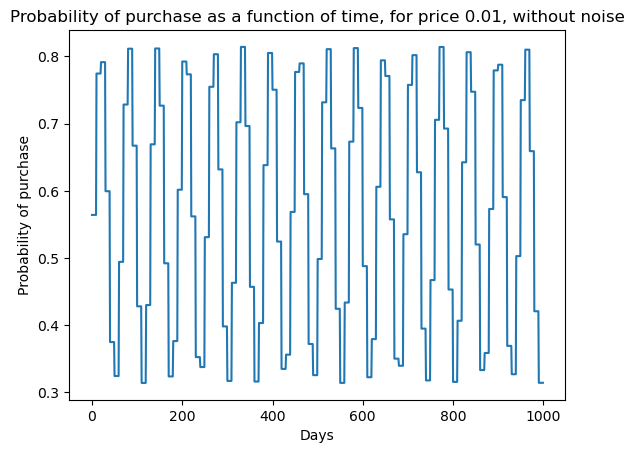

Text(0, 0.5, 'Probability of purchase')

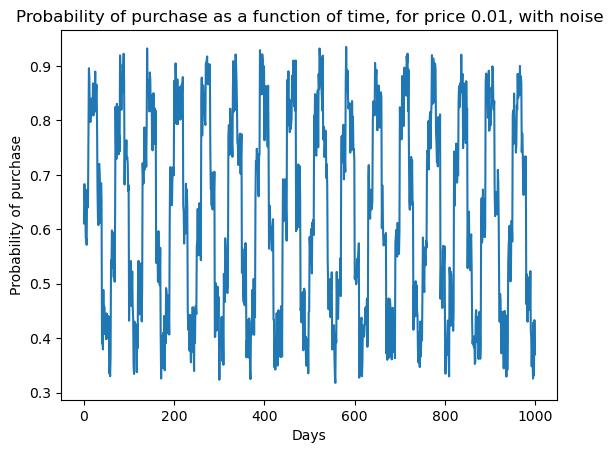

In [25]:
T = 1000
W=math.sqrt(T)
t_interval = range(T)
price = 0.01
probabilities = [conversion_probability_no_noise(price, t) for t in t_interval]
plt.plot(t_interval, probabilities)
plt.title('Probability of purchase as a function of time, for price %.2f, without noise' % price)
plt.xlabel('Days')
plt.ylabel('Probability of purchase')
plt.show()
probabilities = [conversion_probability(price, t) for t in t_interval]
plt.plot(t_interval, probabilities)
plt.title('Probability of purchase as a function of time, for price %.2f, with noise' % price)
plt.xlabel('Days')
plt.ylabel('Probability of purchase')

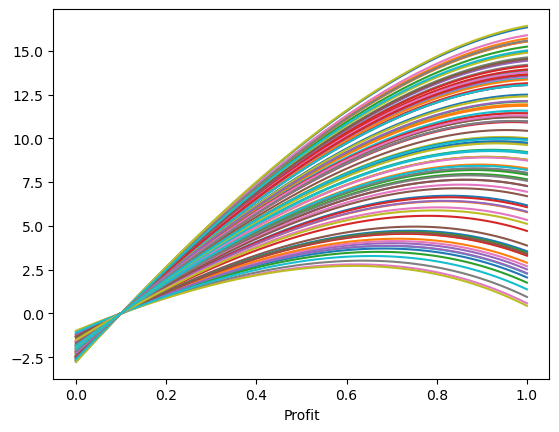

In [6]:
# let's plot the profit curves for different times
t_interval = range(0, 100)
n_users = 30 # just an example

for t in t_interval:
    expected_profit_curve = n_users*conversion_probability(prices, t)*(prices-cost)
    plt.plot(prices, expected_profit_curve)

plt.xlabel('Profit')
plt.show()

# Creating the sliding window UCB agent

In [1]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.a_t] = r_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

# assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)

We will have to adjust the W parameter when calling it.
The W parameter corresponds to the memory we are considering for our model
Mathematically defined by :
$$ W = \left \lfloor 2B\sqrt{T \log T / \Upsilon_T} \right \rfloor,$$

### where $B$ is the maximum reward ($B=1$ for Bernoulli), and $\Upsilon_T$ is the maximum number of times an arm changes its average reward. 
We may have to choose the maximum reward the most adequate

In case of doubt we will take W=square root of T

# CUSUM-UCB agent

In [2]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.range = range
        self.a_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0
    
    def pull_arm(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else:
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.all_rewards[self.a_t].append(r_t)
        if self.counters[self.a_t] == 0:
            if self.change_detection():
                self.n_resets[self.a_t] +=1 
                self.N_pulls[self.a_t] = 0
                self.average_rewards[self.a_t] = 0
                self.counters[self.a_t] = self.M
                self.all_rewards[self.a_t] = []
                self.reset_times[self.a_t] = self.t 
            else:
                self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1

    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False


# Trying the differenst agents

## First the sliding window UCB

In [7]:
#prices == number of arms

print(prices)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

In [12]:
type(probabilities)

list

In [17]:
mu = np.zeros((T, number_of_prices))
for t in range(T):     
    for k in range(number_of_prices):         
        price = PRICES[k]         
        mu[t, k] = conversion_probability(price, t)

type(mu)

numpy.ndarray

In [18]:
# similar implementation of the stationary scenario
class NonstationaryBernoulliEnvironment:
    def __init__(self, mu, T, seed):
        np.random.seed(seed)
        self.mu = np.array(mu)
        self.rewards = np.random.binomial(n=1, p=self.mu.T)
        self.K = self.rewards.shape[1]
        self.t = 0

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

In [28]:
W=int(W)
type(W)

int

In [30]:
# we try a first itaration with T=100 et W=10
T=100
W=10

env = NonstationaryBernoulliEnvironment(mu, T, seed=17)
y = env.rewards
expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = SWUCBAgent(number_of_prices, T,W)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

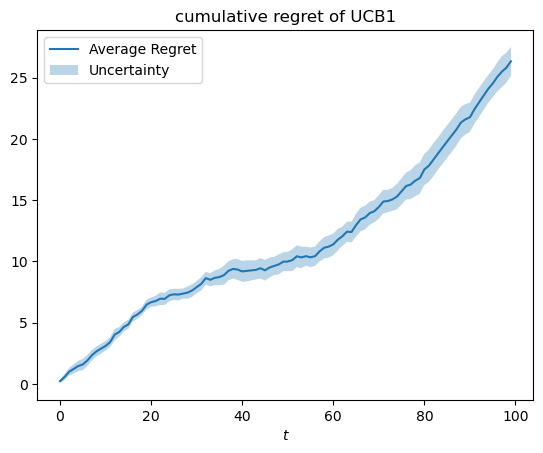

In [38]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

## Try CUSUM

In [35]:
#arbitrary decision on U_T as U_T = sqrt(number_of_prices)
U_T=np.sqrt(number_of_prices)
h = 2*np.log(T/U_T) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T*np.log(T/U_T)/T) # probability of extra exploration

M = int(np.log(T/U_T)) # robustness of change detection
# M = int(np.sqrt(T)) # usually keep M in [log(T/U_T), sqrt(T/U_T)]

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = CUSUMUCBAgent(number_of_prices, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)


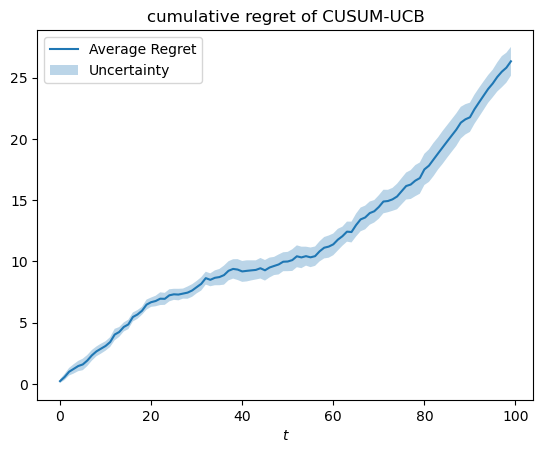

In [37]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()



## Try with a bigger batch
## the result of SW-UCB and CUSUM UCB look too much alike